In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime

In [2]:
# %pip install --upgrade pandas
# !nproc --all
# !top

In [4]:
import networkx as nx
from node2vec import Node2Vec
from shapely.ops import unary_union
from shapely.geometry import Point

# Load road network data
def load_road_network(file_path):
    """
    Load a road network graph.
    The graph should be in an edge-list format or any format compatible with NetworkX.
    """
    # Replace this with your specific method of loading road network data
    # For example, read from an edge list file or construct the graph manually
    graph = nx.read_edgelist(file_path, create_using=nx.Graph(), nodetype=int)
    return graph

def geodataframe_to_graph(gdf, weight_column=None, allowable_distance=0):
    """
    Convert a GeoDataFrame with LineString geometries to a NetworkX graph
    where road segments are nodes, and edges represent connectivity with a
    specified allowable distance for near connections.

    Parameters:
    - gdf: GeoDataFrame containing LineString geometries.
    - weight_column: (Optional) Column name in the GeoDataFrame to use as edge weight.
    - allowable_distance: Maximum allowable distance (in the same units as the CRS) 
                          for considering two segments as connected.

    Returns:
    - G: A NetworkX graph object.
    """
    import networkx as nx
    from shapely.geometry import Point
    from shapely.ops import unary_union

    # Initialize a graph
    G = nx.Graph()

    # Add nodes for road segments
    for idx, row in gdf.iterrows():
        geometry = row.geometry
        if isinstance(geometry, LineString):
            node_attrs = {"geometry": geometry, "index": idx}
            if weight_column and weight_column in row:
                node_attrs["weight"] = row[weight_column]
            G.add_node(idx, **node_attrs)

    # Add edges for connectivity
    for i, row_i in gdf.iterrows():
        if i %100==0: print(datetime.datetime.now(),i,'/',gdf.shape[0])
        line_i = row_i.geometry
        for j, row_j in gdf.iterrows():
            if i >= j:  # Avoid duplicate or self-pairs
                continue
            line_j = row_j.geometry

            # Check for connectivity with allowable distance
            if allowable_distance > 0:
                # Buffer endpoints of both lines
                buffer_i = line_i.boundary.buffer(allowable_distance)
                buffer_j = line_j.boundary.buffer(allowable_distance)

                # Check if buffers intersect
                if buffer_i.intersects(buffer_j):
                    G.add_edge(
                        i, j
                        # distance=buffer_i.distance(buffer_j) if buffer_i.distance(buffer_j) > 0 else 0,
                        # shared_points=None  # Optional: Could store the intersecting points if needed
                    )
            else:
                # Original strict intersection check
                if line_i.intersects(line_j) and line_i.touches(line_j):
                    shared_points = unary_union([line_i.boundary, line_j.boundary])
                    G.add_edge(i, j, shared_points=list(shared_points.coords) if shared_points else None)

    return G
    
# Compute Node2Vec embeddings
def compute_node2vec_embeddings(graph, dimensions=128, walk_length=30, num_walks=200, workers=1):
    """
    Generate graph embeddings using Node2Vec.

    Parameters:
    - graph: NetworkX graph
    - dimensions: Number of dimensions for the embedding
    - walk_length: Length of each random walk
    - num_walks: Number of random walks per node
    - workers: Number of CPU cores to use for parallel processing

    Returns:
    - node_embeddings: A dictionary where keys are node IDs and values are embedding vectors
    """
    # Initialize Node2Vec
    node2vec = Node2Vec(graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)

    # Fit the model and generate embeddings
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Extract embeddings
    node_embeddings = {str(node): model.wv[str(node)] for node in graph.nodes()}
    return node_embeddings

# Save embeddings to a file
def save_embeddings(embeddings, output_file):
    """
    Save node embeddings to a file.
    
    Parameters:
    - embeddings: A dictionary where keys are node IDs and values are embedding vectors
    - output_file: Path to the output file
    """
    with open(output_file, 'w') as f:
        for node, vector in embeddings.items():
            vector_str = ' '.join(map(str, vector))
            f.write(f"{node} {vector_str}\n")

In [5]:
import shapely.geometry as geom

df_road = pd.read_csv("data/TMC_Identification.csv", sep=',', header=0)
df_road = df_road[['tmc_code','intersection','start_latitude','start_longitude','end_latitude','end_longitude','miles']]
print('total number of road segments:',df_road.shape[0])

from shapely.geometry import LineString
from geopandas import GeoDataFrame

df_road['geometry'] = df_road.apply(
    lambda row: LineString([(row['start_longitude'], row['start_latitude']),
                             (row['end_longitude'], row['end_latitude'])]),
    axis=1
)

# Create a GeoDataFrame for road network
gdf_road = GeoDataFrame(df_road, geometry='geometry',crs="EPSG:4326")
gdf_road = gdf_road.to_crs(epsg=3857)
# gdf_road.explore()

total number of road segments: 4460


In [6]:
gdf_road.head()

,tmc_code,intersection,start_latitude,start_longitude,end_latitude,end_longitude,miles,geometry
0,112P13033,W MARTIN LUTHER KING JR BLVD,30.28172,-97.74193,30.28232,-97.74207,0.04249,"LINESTRING (-10880581.877 3539813.967, -10880597.461 3539891.312)"
1,112+08908,FM-20,30.11066,-97.41049,30.11082,-97.37323,2.22783,"LINESTRING (-10843686.145 3517782.1, -10839538.38 3517802.69)"
2,112+16538,GATTIS SCHOOL RD,30.49057,-97.67514,30.49351,-97.67573,0.20831,"LINESTRING (-10873146.848 3566765.192, -10873212.526 3567144.998)"
3,112+16539,RM-620/ROUND ROCK AVE,30.49351,-97.67573,30.50861,-97.67882,1.06718,"LINESTRING (-10873212.526 3567144.998, -10873556.504 3569095.887)"
4,112P13038,N LAMAR BLVD,30.31662,-97.73208,30.31704,-97.73188,0.03140,"LINESTRING (-10879485.38 3544313.663, -10879463.116 3544367.823)"


In [8]:
%%time # this takes 38min
G = geodataframe_to_graph(gdf_road,allowable_distance=20)  # allowable_distance unit is meter because CRS is 3857
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

0 / 4460
100 / 4460
200 / 4460
300 / 4460
400 / 4460
500 / 4460
600 / 4460
700 / 4460
800 / 4460
900 / 4460
1000 / 4460
1100 / 4460
1200 / 4460
1300 / 4460
1400 / 4460
1500 / 4460
1600 / 4460
1700 / 4460
1800 / 4460
1900 / 4460
2000 / 4460
2100 / 4460
2200 / 4460
2300 / 4460
2400 / 4460
2500 / 4460
2600 / 4460
2700 / 4460
2800 / 4460
2900 / 4460
3000 / 4460
3100 / 4460
3200 / 4460
3300 / 4460
3400 / 4460
3500 / 4460
3600 / 4460
3700 / 4460
3800 / 4460
3900 / 4460
4000 / 4460
4100 / 4460
4200 / 4460
4300 / 4460
4400 / 4460
Number of nodes: 4460
Number of edges: 14420
CPU times: user 38min 49s, sys: 55.4 ms, total: 38min 49s
Wall time: 38min 49s


In [12]:
# nx.write_graphml(G, "./output/graph_embeddings_graph.graphml")
# G = nx.read_graphml("graph.graphml")

In [15]:
import pickle

with open("./output/graph_embeddings_graph.pkl", "wb") as f:
    pickle.dump(G, f)
# Load back the graph
# with open("graph.pkl", "rb") as f:
#     G_loaded = pickle.load(f)

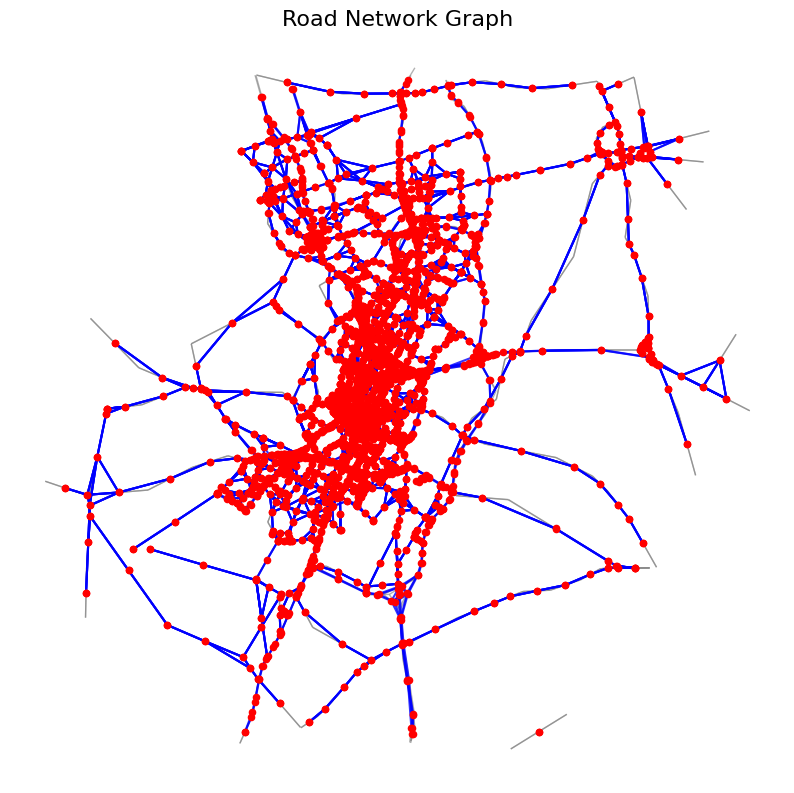

CPU times: user 2min 13s, sys: 1.72 s, total: 2min 15s
Wall time: 2min 13s


In [91]:
%%time 

import matplotlib.pyplot as plt
import networkx as nx

def plot_graph_on_map(G, gdf):
    """
    Plot the NetworkX graph G on top of the original GeoDataFrame.

    Parameters:
    - G: NetworkX graph object.
    - gdf: GeoDataFrame with the original road network geometries.
    """
    # Plot the base road network
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color='gray', linewidth=1, alpha=0.6)

    # Extract graph edges and plot them
    for u, v, data in G.edges(data=True):
        geom_u = G.nodes[u]["geometry"]
        geom_v = G.nodes[v]["geometry"]

        # Draw edges as line connections between nodes
        x_coords = [geom_u.centroid.x, geom_v.centroid.x]
        y_coords = [geom_u.centroid.y, geom_v.centroid.y]
        ax.plot(x_coords, y_coords, color='blue', linewidth=1.5, alpha=0.8, zorder=2)

    # Draw nodes
    for node, data in G.nodes(data=True):
        ax.scatter(
            data["geometry"].centroid.x,
            data["geometry"].centroid.y,
            color='red',
            s=20,
            zorder=3
        )

    ax.set_title("Road Network Graph", fontsize=16)
    plt.axis("off")
    plt.show()


# Plot the graph
plot_graph_on_map(G, gdf_road)

In [16]:
%%time #takes 
print("Generating Node2Vec embeddings...")
embeddings = compute_node2vec_embeddings(G, dimensions=32, walk_length=30, num_walks=200, workers=1)

Generating Node2Vec embeddings...


Computing transition probabilities:   0%|          | 0/4460 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████████████████████| 200/200 [01:30<00:00,  2.22it/s]


CPU times: user 20min 24s, sys: 2min 1s, total: 22min 26s
Wall time: 17min 6s


In [18]:
# Save embeddings to a file
import datetime

output_file = "./output/road_network_embeddings"+str(datetime.datetime.now())+".txt"
print(f"Saving embeddings to {output_file}...")
save_embeddings(embeddings, output_file)
print("Done!")

Saving embeddings to ./output/road_network_embeddings2025-02-06 14:11:23.230782.txt...
Done!


In [19]:
print(len(embeddings.keys()))
print(gdf_road.tmc_code.unique().shape[0])

embedding_dim = len(next(iter(embeddings.values())))  # Dimension of embeddings
embeddings_df = pd.DataFrame.from_dict(embeddings, orient='index', columns=[f"embedding_{i}" for i in range(embedding_dim)])
embeddings_df.index.name = "index"  # Name index for merging later
embeddings_df.index = embeddings_df.index.astype(int)
embeddings_df.head()

4460
4460


,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.24324,-1.55922,1.79760,0.03694,-0.52107,-0.55086,-1.16012,0.48523,-0.91719,-0.01550,-0.33068,0.61187,-0.01463,-0.36192,0.28315,0.78325,-1.53255,-0.26653,0.03132,0.18842,0.97826,1.52112,-0.96194,-1.53848,-0.92310,-0.65152,-1.78580,0.15968,-0.63275,0.37145,-0.32096,-0.82477
1,0.35304,-1.63690,1.20682,-1.60133,0.36512,-0.87568,-0.49860,-0.46996,0.72863,-0.52245,0.33003,-0.61544,0.65397,-0.66348,0.38039,0.65418,-2.53654,1.37988,-0.22644,-0.41879,-0.69916,0.71573,0.10038,-0.94658,0.39912,1.08014,-0.56337,1.41046,-0.71373,-1.30380,-0.58924,-0.24473
2,0.40141,0.05486,0.43638,-0.50673,-1.18437,0.24588,-0.08270,0.97471,0.73522,0.39329,0.19026,-0.44870,1.32620,-1.67857,0.87724,0.55235,-1.45682,0.84685,0.07033,0.49291,0.02069,0.55207,-0.73907,-0.91978,1.12346,-0.05283,-0.97256,-0.36229,0.17603,1.51269,0.67826,-0.36664
3,0.17930,-0.00227,0.72566,-0.37563,-0.89482,0.09159,-0.16741,0.79085,0.74201,0.20842,0.30178,-0.13397,1.44459,-1.73636,0.93985,0.79855,-1.45508,1.13941,0.26663,0.45772,0.08776,0.69590,-0.87947,-0.81852,0.87510,-0.11858,-1.13689,-0.46781,0.28055,1.30322,0.94670,-0.03024
4,0.42498,-2.12734,0.92628,-0.91008,0.03211,-0.78300,0.26916,0.69397,-0.24254,0.19883,-0.52670,1.26883,0.36198,-0.26862,0.14856,1.05288,-1.60410,0.20108,-0.58838,0.83618,0.14655,-0.09476,-1.14069,-1.26745,-0.89071,1.01520,-0.18214,-0.32107,0.20370,0.18266,-0.14595,-0.21889


In [20]:
gdf_road.index.name = "index"
gdf_road.index = gdf_road.index.astype(int)
gdf_road.head()

,tmc_code,intersection,start_latitude,start_longitude,end_latitude,end_longitude,miles,geometry
index,,,,,,,,
0,112P13033,W MARTIN LUTHER KING JR BLVD,30.28172,-97.74193,30.28232,-97.74207,0.04249,"LINESTRING (-10880581.877 3539813.967, -10880597.461 3539891.312)"
1,112+08908,FM-20,30.11066,-97.41049,30.11082,-97.37323,2.22783,"LINESTRING (-10843686.145 3517782.1, -10839538.38 3517802.69)"
2,112+16538,GATTIS SCHOOL RD,30.49057,-97.67514,30.49351,-97.67573,0.20831,"LINESTRING (-10873146.848 3566765.192, -10873212.526 3567144.998)"
3,112+16539,RM-620/ROUND ROCK AVE,30.49351,-97.67573,30.50861,-97.67882,1.06718,"LINESTRING (-10873212.526 3567144.998, -10873556.504 3569095.887)"
4,112P13038,N LAMAR BLVD,30.31662,-97.73208,30.31704,-97.73188,0.03140,"LINESTRING (-10879485.38 3544313.663, -10879463.116 3544367.823)"


In [21]:
# Merge embeddings back into the GeoDataFrame
gdf_with_embeddings = gdf_road[['tmc_code']].merge(embeddings_df, left_index=True, right_index=True, how="left")
gdf_with_embeddings.head()

,tmc_code,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,112P13033,0.24324,-1.55922,1.79760,0.03694,-0.52107,-0.55086,-1.16012,0.48523,-0.91719,-0.01550,-0.33068,0.61187,-0.01463,-0.36192,0.28315,0.78325,-1.53255,-0.26653,0.03132,0.18842,0.97826,1.52112,-0.96194,-1.53848,-0.92310,-0.65152,-1.78580,0.15968,-0.63275,0.37145,-0.32096,-0.82477
1,112+08908,0.35304,-1.63690,1.20682,-1.60133,0.36512,-0.87568,-0.49860,-0.46996,0.72863,-0.52245,0.33003,-0.61544,0.65397,-0.66348,0.38039,0.65418,-2.53654,1.37988,-0.22644,-0.41879,-0.69916,0.71573,0.10038,-0.94658,0.39912,1.08014,-0.56337,1.41046,-0.71373,-1.30380,-0.58924,-0.24473
2,112+16538,0.40141,0.05486,0.43638,-0.50673,-1.18437,0.24588,-0.08270,0.97471,0.73522,0.39329,0.19026,-0.44870,1.32620,-1.67857,0.87724,0.55235,-1.45682,0.84685,0.07033,0.49291,0.02069,0.55207,-0.73907,-0.91978,1.12346,-0.05283,-0.97256,-0.36229,0.17603,1.51269,0.67826,-0.36664
3,112+16539,0.17930,-0.00227,0.72566,-0.37563,-0.89482,0.09159,-0.16741,0.79085,0.74201,0.20842,0.30178,-0.13397,1.44459,-1.73636,0.93985,0.79855,-1.45508,1.13941,0.26663,0.45772,0.08776,0.69590,-0.87947,-0.81852,0.87510,-0.11858,-1.13689,-0.46781,0.28055,1.30322,0.94670,-0.03024
4,112P13038,0.42498,-2.12734,0.92628,-0.91008,0.03211,-0.78300,0.26916,0.69397,-0.24254,0.19883,-0.52670,1.26883,0.36198,-0.26862,0.14856,1.05288,-1.60410,0.20108,-0.58838,0.83618,0.14655,-0.09476,-1.14069,-1.26745,-0.89071,1.01520,-0.18214,-0.32107,0.20370,0.18266,-0.14595,-0.21889


In [22]:
gdf_with_embeddings.to_csv('./output/network_embeddings'+str(datetime.datetime.now())+'.csv',index=False)

In [136]:
# def flatten_embeddings(df, embedding_column):
#     # Expand embeddings into separate columns
#     embeddings_df = pd.DataFrame(df[embedding_column].tolist(), index=df.index)
#     embeddings_df.columns = [embedding_column + f"_{i}" for i in range(embeddings_df.shape[1])]
#     return pd.concat([df.drop(columns=[embedding_column]), embeddings_df], axis=1)
# gdf_with_embeddings_flat = flatten_embeddings(gdf_with_embeddings, 'mean_embedding')

In [ ]:
# gdf_with_embeddings_flat = flatten_embeddings(gdf_with_embeddings_flat, 'start_node_embedding')
# gdf_with_embeddings_flat = flatten_embeddings(gdf_with_embeddings, 'start_node_embedding')
# gdf_with_embeddings_flat.drop(['start_node_embedding','end_node_embedding'], axis=1, inplace=True)